In [1]:
from tqdm import tqdm

from tools.analysis_utils import (
    import_known_tokens,
    compile_scores,
    convert_raw,
    vjui
)

In [2]:
TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")


In [3]:
KNOWN_TOKENS, KNOWN_LEMMAS = import_known_tokens()

# Analyse sur le hors domaine textes tardifs

## Lien Texte / URN

In [4]:
data = """Tertullien, De pallio, III (570 mots) : urn:cts:latinLit:stoa0275.stoa022.opp-lat1:3
Tertullien, De spectaculis, IX-X (642 mots) : urn:cts:latinLit:stoa0275.stoa027.opp-lat2:9-10
Grégoire de Tours, Historia Francorum, II, 30-31 (548 mots) : urn:cts:latinLit:stoa0143.stoa001:@.30-2.31
Augustin, De civitate Dei, XVII, 4 (555 mots) : urn:cts:latinLit:stoa0040.stoa003.opp-lat4:17.4
Augustin, Lettre CCLXII, 1-4 (582 mots) : urn:cts:latinLit:stoa0040.stoa011.opp-lat4:262.1-262.4
Sulpice Sévère, Vita Martini, IX-X (519 mots) : urn:cts:latinLit:stoa0270.stoa002.opp-lat2:9-10
Prudence, Psychomachie, préface et 1-20 (519 mots) : urn:cts:latinLit:stoa0238.stoa002.perseus-lat2:pr.1-1.20
Commodien, Instructiones, I, 35-37 (432 mots) : urn:cts:latinLit:stoa0096.stoa003.opp-lat2:1.35-1.37
Cyprien de Carthage, De unitate Ecclesiae, VI-VIII (663 mots) : urn:cts:latinLit:stoa0104a.stoa010.opp-lat1:6-8
Salvien de Marseille, De gubernatione Dei, VI, 10-11 (540 mots) : urn:cts:latinLit:stoa0249a.stoa002.opp-lat1:6.53-6.60
Jean Cassien, Institutiones, VIII, 8-10 (553 mots) : urn:cts:latinLit:stoa0076c.stoa002.opp-lat2:8.8-8.10
Sidoine Apollinaire, Lettres, IV, 3 (730 mots) :  urn:cts:latinLit:stoa0261.stoa002:4.3
Ambroise de Milan, De Tobia, 1-8 (576 mots) : urn:cts:latinLit:stoa0022.stoa044.opp-lat1:1-8
Bède le Vénérable, De locis sanctis, I-II (647 mots) : urn:cts:latinLit:stoa0054.stoa001a.opp-lat1:1-2
Hilaire de Poitiers, Tractatus super psalmos, II, 1-4 (600 mots) : urn:cts:latinLit:stoa0149b.stoa001.opp-lat1:2
Lactance, De mortibus persecutorum, 26-27 (579 mots) : urn:cts:latinLit:stoa0171.stoa002.opp-lat1:26-27
Jérôme, Commentaire sur Jérémie, I, 1, 1-2, 3 (514 mots) : urn:cts:latinLit:stoa0162.stoa024.opp-lat1:1.1.1-1.2.3
Boèce, Contra Eutychen et Nestorium, III (714 mots) : urn:cts:latinLit:stoa0058.stoa023.perseus-lat1:3
Eginhard, Vie de Charlemagne, I-III (631 mots) : urn:cts:latinLit:stoa0112.stoa001:1-3""".split("\n")
TextsTitles = dict([("urn:"+line.split("urn:")[-1], ",".join(line.split(",")[:2])) for line in data])
print(TextsTitles)

{'urn:cts:latinLit:stoa0275.stoa022.opp-lat1:3': 'Tertullien, De pallio', 'urn:cts:latinLit:stoa0275.stoa027.opp-lat2:9-10': 'Tertullien, De spectaculis', 'urn:cts:latinLit:stoa0143.stoa001:@.30-2.31': 'Grégoire de Tours, Historia Francorum', 'urn:cts:latinLit:stoa0040.stoa003.opp-lat4:17.4': 'Augustin, De civitate Dei', 'urn:cts:latinLit:stoa0040.stoa011.opp-lat4:262.1-262.4': 'Augustin, Lettre CCLXII', 'urn:cts:latinLit:stoa0270.stoa002.opp-lat2:9-10': 'Sulpice Sévère, Vita Martini', 'urn:cts:latinLit:stoa0238.stoa002.perseus-lat2:pr.1-1.20': 'Prudence, Psychomachie', 'urn:cts:latinLit:stoa0096.stoa003.opp-lat2:1.35-1.37': 'Commodien, Instructiones', 'urn:cts:latinLit:stoa0104a.stoa010.opp-lat1:6-8': 'Cyprien de Carthage, De unitate Ecclesiae', 'urn:cts:latinLit:stoa0249a.stoa002.opp-lat1:6.53-6.60': 'Salvien de Marseille, De gubernatione Dei', 'urn:cts:latinLit:stoa0076c.stoa002.opp-lat2:8.8-8.10': 'Jean Cassien, Institutiones', 'urn:cts:latinLit:stoa0261.stoa002:4.3': 'Sidoine Apol

## Import des données

In [5]:
Texts = []
GOLD = []

EndToken = 7088 # As per Anthony's sheet
nb_tokens = 0

def filter_gold(data):
    return [lst for lst in data if lst]

with open("/home/thibault/dev/latin-non-classical-data/latin-chretien-v2.tsv") as f:
    header = []
    current_text = None
    for lineno, line in enumerate(f):
        line = line.strip().split("\t")
        if lineno == 0:
            header = line
            continue
        line = dict(zip(header, line))
        
        if line["form"].startswith("urn:"):
            GOLD = filter_gold(GOLD)
            Texts.append((line["form"], nb_tokens, len(GOLD)))
            GOLD.append([])
            continue
        
        if line["POS"] == "PUNC":
            if line["lemma"] in ".!?":
                if GOLD[-1] != []:
                    GOLD = filter_gold(GOLD)
                    GOLD.append([])
        else:
            GOLD[-1].append(line)
            nb_tokens += 1
            
        
        if lineno+1 == EndToken:
            break   

if GOLD[-1] == []:
    GOLD = GOLD[:-1]
print(f"{len(Texts)} texts found")
print(f"{len(GOLD)} sentences found")
if False:
    for tok in GOLD[0]:
        print(tok)
    for text in Texts:
        print(text)

8 texts found
304 sentences found


## Transformation et expansion des champs 

In [6]:
PLATINUM = convert_raw(GOLD, task_list=TASKS, lemma_fn=vjui, form_fn=vjui)

100%|██████████| 304/304 [00:00<00:00, 15687.55it/s]


## Récupération des tokens uniquement


In [7]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in PLATINUM
]

## Test

In [8]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 128


OUTPUT = []
MODEL_PATH = "../../../latin-lasla-models/model.tar"

tagger = Tagger(device="cpu", batch_size=100, lower=False, tokenize=False)
tagger.add_model(MODEL_PATH, *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])

4it [00:07,  1.96s/it]


In [9]:
#tasks
#OUTPUT

## Compilation des résultats

In [10]:
from collections import defaultdict, Counter



RESULTS, RAW_SCORES, RAW_SCORES_NOT_EMPTY, ERRORS, SCORES_KNOWN = compile_scores(
    OUTPUT, PLATINUM, task_list=TASKS, known_tokens=KNOWN_TOKENS, known_lemmas=KNOWN_LEMMAS
)

# Scores

## Scores généraux

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

data = [["Task", "Accuracy", "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.3f}".format(accuracy_score(truth, pred)),
        "{0:.3f}".format(accuracy_score(pred_limited, truth_limited))
    ])
print(tabulate(data))

----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.951     0.951
Deg               0.977     0.940
Numb              0.972     0.969
Person            0.998     0.994
Mood_Tense_Voice  0.978     0.922
Case              0.932     0.883
Gend              0.888     0.629
pos               0.947     0.947
----------------  --------  ------------------


```
----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.951     0.951
Deg               0.977     0.940
Numb              0.972     0.969
Person            0.998     0.994
Mood_Tense_Voice  0.978     0.922
Case              0.932     0.883
Gend              0.888     0.629
pos               0.947     0.947
----------------  --------  ------------------
```

## Établissement d'une liste des confusions

In [12]:
ERRORS["lemma"]

with open("1.4.X-LatinTardif-Lemma-Confusion.tsv", "w") as f:
    f.write("lemma\tprediction\ttoken\tnumber\n")
    print("lemma\tprediction\ttoken\tnumber")
    for lemma in ERRORS["lemma"]:
        for pred in ERRORS["lemma"][lemma]:
            for token, count in ERRORS["lemma"][lemma][pred].items():
                f.write(f"{lemma}\t{pred}\t{token}\t{count}\n")
                print(f"{lemma}\t{pred}\t{token}\t{count}")

lemma	prediction	token	number
cataclita	cataxlestus	cataclistis	1
syrma	syrmates	syrmate	1
hyaena	Hyaena	Hyaenam	1
pascor	pasco	pastus	1
tardigradus	tardigra	tardigrada	1
oppido	oppidum	oppido	1
chamaeleon	Chamaeleon	Chamaeleontem	1
chamaeleon	Chamaele	Chamaeleon	1
chamaeleon	chamaele	chamaeleon	1
chamaeleon	chamaeles	chamaeleonti	1
amplus	ample	amplius	1
quod	qui	quod	2
uertigino	uertigo	uertiginant	1
inuestis	inuestus	inuestis	1
licitus	licet	licitum	1
licitus	licet	licita	1
qui	quod	quod	7
qui	quod	Quod	1
qui	quis	qui	1
qui	quis	Quas	1
qui	quis	quo	1
qui	quo	quo	1
Osiris	Osirides	Osiridis	1
Ammon	ammon	Ammon	1
palpo	palpatus	palpati	1
lanicium	lanicia	lanicii	1
Arachne	Arachnes	Arachnen	1
Baetica	Baeticus	Baetica	1
lautus	plautus	plautiores	1
aer	aes	aerem	1
liquo	liquor	liquando	1
uestificinus	uestificium	uestificinae	1
qua	qui	qua	1
ceteri	ceterus	ceteris	1
Graecus	Graeci	Graecos	2
exsertus	exsero	exertus	1
daemonium	daemonius	daemoniorum	1
daemonium	daemonia	daemonia	1
Sol	solus	

## Visualisation sur le corpus

In [13]:
print(Texts)

MilestonesSentences = [
    (tid, begin, end)
    for (tid, _, begin), (_, _, end) in zip(Texts, Texts[1:]+[(None, None, None)])
] # Those are sentences IDs

def count_tokens(begin, end):
    return len([tok for sent in PLATINUM[begin:end] for tok in sent])

print(MilestonesSentences)
MILESTONES = [count_tokens(beg, end) for _, beg, end in MilestonesSentences]
MILESTONES = [sum(MILESTONES[:index]) + value for index, value in enumerate(MILESTONES)]

SPLITS_TASK = {
    task: []
    for task in RAW_SCORES
}
SIZES = []


lengths = []
support_done = False
for task, (pred, truth) in RAW_SCORES.items():
    ms_start = 0
    for milestone in MILESTONES:
        SPLITS_TASK[task].append(accuracy_score(truth[ms_start:milestone], pred[ms_start:milestone]))
        length = milestone - ms_start + 1
        if not support_done:
            SIZES.append(length)
        ms_start = milestone
    support_done = True

[('urn:cts:latinLit:stoa0275.stoa022.opp-lat1:3', 0, 0), ('urn:cts:latinLit:stoa0275.stoa027.opp-lat2:9-10', 561, 34), ('urn:cts:latinLit:stoa0040.stoa003.opp-lat4:17.4', 1184, 70), ('urn:cts:latinLit:stoa0040.stoa011.opp-lat4:262.1-262.4', 3657, 193), ('urn:cts:latinLit:stoa0270.stoa002.opp-lat2:9-10', 4234, 211), ('urn:cts:latinLit:stoa0238.stoa002.perseus-lat2:pr.1-1.20', 4743, 238), ('urn:cts:latinLit:stoa0096.stoa003.opp-lat2:1.35-1.37', 5211, 251), ('urn:cts:latinLit:stoa0104a.stoa010.opp-lat1:6-8', 5625, 287)]
[('urn:cts:latinLit:stoa0275.stoa022.opp-lat1:3', 0, 34), ('urn:cts:latinLit:stoa0275.stoa027.opp-lat2:9-10', 34, 70), ('urn:cts:latinLit:stoa0040.stoa003.opp-lat4:17.4', 70, 193), ('urn:cts:latinLit:stoa0040.stoa011.opp-lat4:262.1-262.4', 193, 211), ('urn:cts:latinLit:stoa0270.stoa002.opp-lat2:9-10', 211, 238), ('urn:cts:latinLit:stoa0238.stoa002.perseus-lat2:pr.1-1.20', 238, 251), ('urn:cts:latinLit:stoa0096.stoa003.opp-lat2:1.35-1.37', 251, 287), ('urn:cts:latinLit:stoa

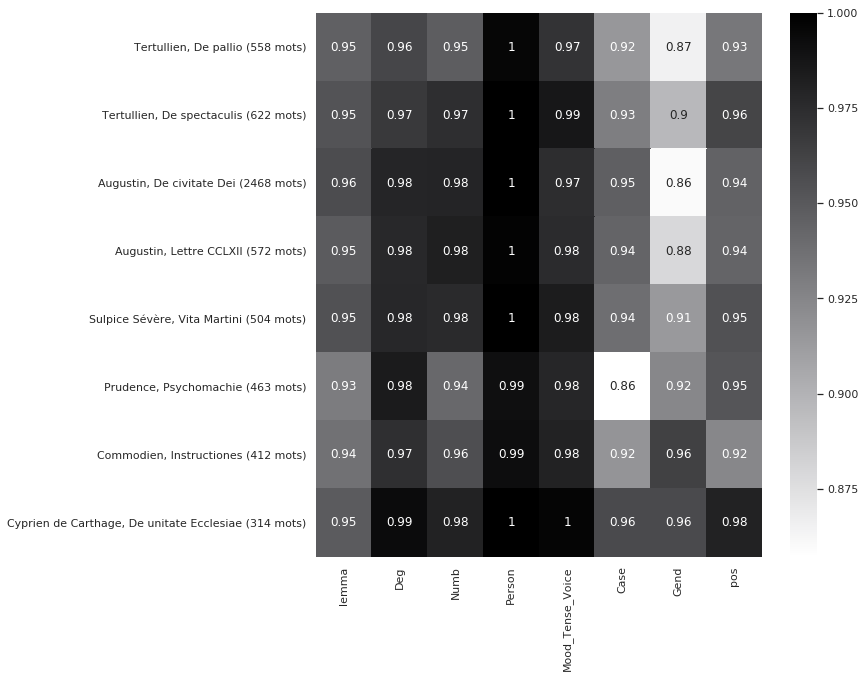

In [14]:
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

DF_Tardif = DataFrame(SPLITS_TASK, index=[
    "{} ({} mots)".format(TextsTitles[tid], length) for (tid, *_), length in zip(MilestonesSentences, SIZES)
])

plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(DF_Tardif, annot=True, cmap=cmap)

## Visualisation sur le corpus par POS GOLD

### Recompilation PLATINUM avec NOMpro / NOMcom

In [15]:
PLATINUM_NOMpro = convert_raw(GOLD, task_list=TASKS, lemma_fn=vjui, form_fn=vjui, pos_fn=lambda x: x)

100%|██████████| 304/304 [00:00<00:00, 16232.98it/s]


In [16]:
from collections import defaultdict

# Dict[Text_id, Dict[POS, [0, 1]]] where 0 = false, 1 = true
Stats_Per_Pos = defaultdict(lambda :defaultdict(list))
_, Scores_Nom_Pro, *_, Score_Knowns = compile_scores(OUTPUT, PLATINUM_NOMpro, 
                                                     task_list=TASKS, known_tokens=KNOWN_TOKENS, 
                                                    known_lemmas=KNOWN_LEMMAS)


start = 0
for text_id, end in enumerate(MILESTONES):
    for (lemma_pred, lemma_truth,  pos_truth) in zip(
        Scores_Nom_Pro["lemma"][0][start:end],
        Scores_Nom_Pro["lemma"][1][start:end],
        Scores_Nom_Pro["pos"][1][start:end]
    ):
        Stats_Per_Pos[text_id][pos_truth].append(int(lemma_pred == lemma_truth))
    start = end

## Now we compute the accuracy and the weight of each POS (in %)

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


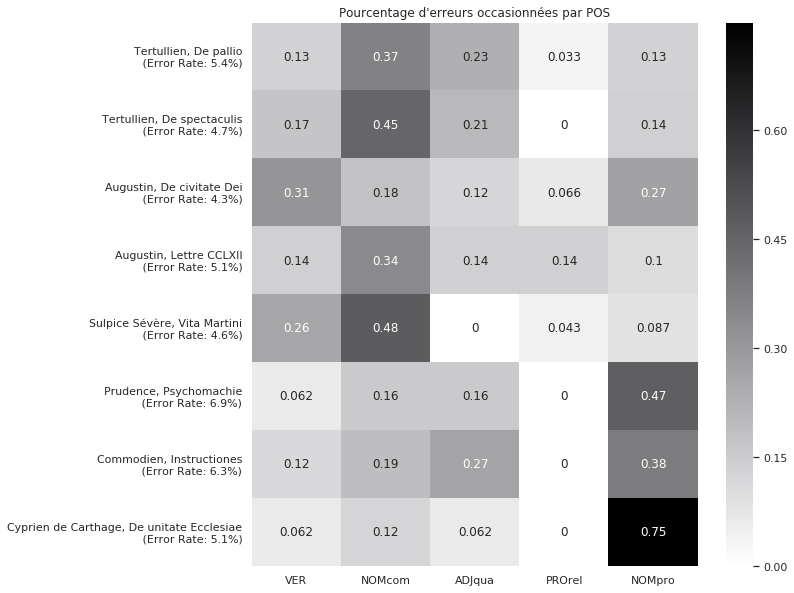

In [17]:
from collections import namedtuple
TextInformation = namedtuple("TextInformation", ["title", "size", "error_rate"])
TextTitleSize = [
    TextInformation(TextsTitles[tid], length, 1-accuracy) 
    for (tid, *_), length, accuracy in zip(
        MilestonesSentences, SIZES, SPLITS_TASK["lemma"]
    )
]

LIMIT_TO_POS = {"VER", "NOMcom", "NOMpro", "PROrel", "ADJqua"}


def compute_accuracy(trues, corpus_size, corpus_accuracy) -> int:
    return ((len(trues) - sum(trues)) / corpus_size) / corpus_accuracy

Impact_Acc_Per_Pos = DataFrame({
    f"{TextTitleSize[text_id].title}\n (Error Rate: {TextTitleSize[text_id].error_rate*100:.1f}%)": {
        pos: compute_accuracy(equals, TextTitleSize[text_id].size, TextTitleSize[text_id].error_rate)
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
    }
    for text_id, texts_values in Stats_Per_Pos.items()
}).transpose()


# Impact_Acc_Per_Pos[f"Total {len(LIMIT_TO_POS)} POS"] = Impact_Acc_Per_Pos[f"Total {len(LIMIT_TO_POS)} POS"].sum()

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig = plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(Impact_Acc_Per_Pos, annot=True, cmap=cmap)
ax.set_title("Pourcentage d'erreurs occasionnées par POS")
fig.show()

### Impact on Accuracy vs. Size in Corpus

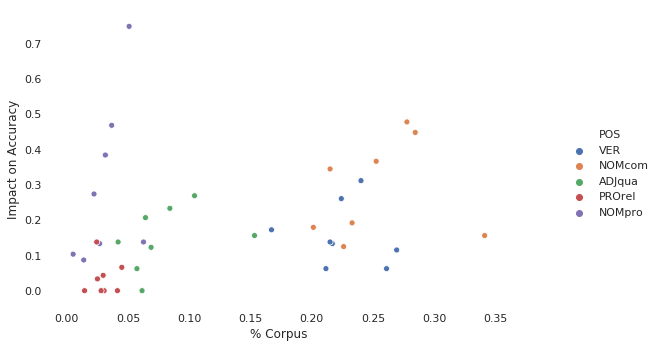

In [18]:
ScatterPos = DataFrame([
    {
        "POS": pos,
        "% Corpus": len(equals)/TextTitleSize[text_id].size, 
        "Impact on Accuracy": compute_accuracy(
            equals,
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        )
    }
    for text_id, texts_values in Stats_Per_Pos.items()
        for pos, equals in texts_values.items()
        if pos in LIMIT_TO_POS
])
g = sns.relplot(
    x="% Corpus", y="Impact on Accuracy", hue="POS", 
    data=ScatterPos, 
    cmap=sns.husl_palette(len(LIMIT_TO_POS))
)
g.fig.set_size_inches(10,5)
g.fig.show()

### Impact on Accuracy vs. Size in Corpus

We remove PROrel because they are all known

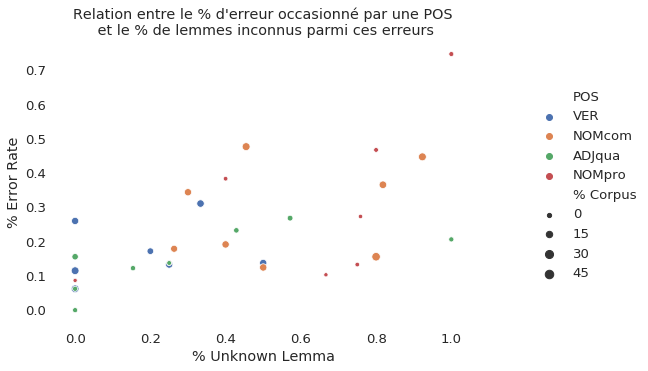

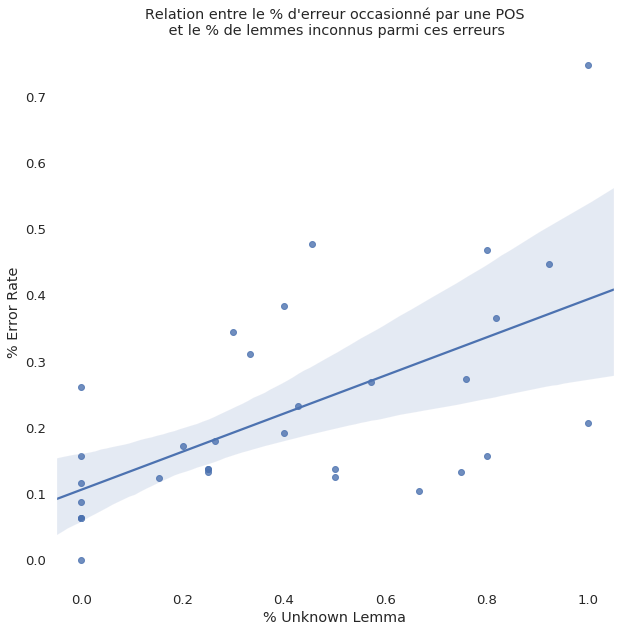

In [19]:
# Compile data to take into account LEMMA and POS
LIMIT_TO_POS_UNKNOWN = {"VER", "NOMcom", "NOMpro", "ADJqua"}
LemmaPosUnknown = defaultdict(lambda :defaultdict(lambda: defaultdict(list)))
start = 0


for text_id, end in enumerate(MILESTONES):
    for token in Score_Knowns[start:end]:
        LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["Accuracy"].append(int(token["lemma"]))
        
        if not token["lemma"]:  # If lemmatization is wrong
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownTokens"].append(
                int(token["known_token"])
            )
            LemmaPosUnknown[text_id][token["GOLD"]["pos"]]["KnownLemmas"].append(
                int(token["known_lemma"])
            )
    start = end
    
def compute_rate_unknown(score, key):
    if score[key]:
        return 1 - sum(score[key]) / len(score[key])
    return 0

LemmaPosUnknownDataFrame = DataFrame([
    {
        "POS": pos,
        "% Error Rate": compute_accuracy(
            score["Accuracy"],
            TextTitleSize[text_id].size,
            TextTitleSize[text_id].error_rate
        ),
        "% Unknown Tokens": compute_rate_unknown(score, "KnownTokens"),
        "% Unknown Lemma": compute_rate_unknown(score, "KnownLemmas"),
        "% Corpus": round(100*len(score["Accuracy"])/TextTitleSize[text_id].size)
    }
    for text_id, text_values in LemmaPosUnknown.items()
    for pos, score in text_values.items()
    if pos in LIMIT_TO_POS_UNKNOWN
])

with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.relplot(
        x="% Unknown Lemma", y="% Error Rate", hue="POS", 
        size="% Corpus",
        data=LemmaPosUnknownDataFrame, 
        cmap=sns.husl_palette(len(LIMIT_TO_POS))
    )
    g.fig.set_size_inches(10,5)
    g.fig.axes[0].set_title("Relation entre le % d'erreur occasionné par une POS"
                            "\n et le % de lemmes inconnus parmi ces erreurs")
    g.fig.show()
    
with sns.plotting_context("notebook", font_scale=1.2):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.regplot(
        x="% Unknown Lemma", y="% Error Rate",
        data=LemmaPosUnknownDataFrame,
        ax=ax
    )
    ax.set_title("Relation entre le % d'erreur occasionné par une POS"
                            "\n et le % de lemmes inconnus parmi ces erreurs")
    fig.show()